In [37]:
!pip install tensorflow-docs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.7/182.7 kB 6.7 MB/s eta 0:00:00


In [38]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from IPython import display

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [22]:

BATCH_SIZE = 128
IMG_HEIGHT = 64
IMG_WIDTH = 64
CHANNELS = 3  


dataset_path = '/kaggle/input/animefacedataset/images'

def load_and_process_image(path):

    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=CHANNELS)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = (img - 127.5) / 127.5
    return img

image_paths = tf.data.Dataset.list_files(str(dataset_path + '/*.jpg'))

print(f"Found {len(list(image_paths))} images.")

train_dataset = image_paths.map(load_and_process_image, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)



Found 63565 images.


/tmp/ipykernel_47/780813154.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(4, 5, i + 1)


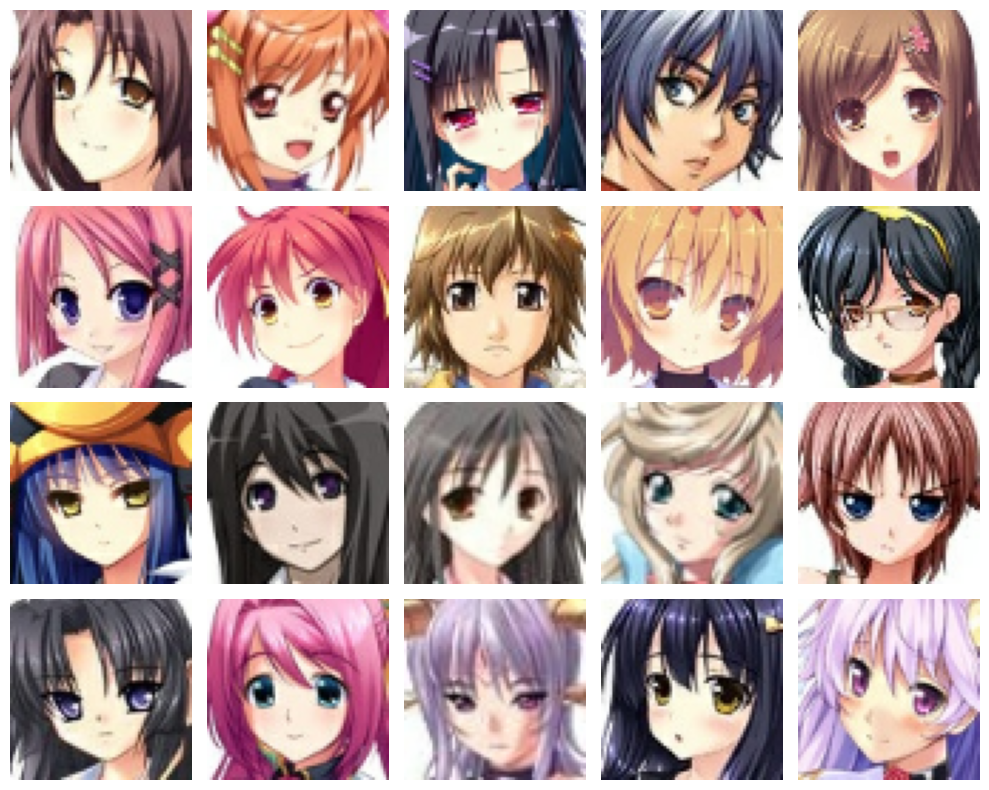

In [23]:
import matplotlib.pyplot as plt


image_batch = next(iter(train_dataset))


plt.figure(figsize=(10, 8))
plt.title("Real Images from Dataset")

for i in range(20):
    ax = plt.subplot(4, 5, i + 1) 
    
   
    img = image_batch[i]

    img = (img + 1) / 2.0
    
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [24]:
def make_generator_model():
    model = tf.keras.Sequential()
    

    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((4, 4, 512)))



    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())


    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())


    model.add(layers.Conv2DTranspose(CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))


    return model

generator = make_generator_model()
print(generator.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 8192)           │       819,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 8, 8, 256)      │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 3)      │         4,800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,159,360 (19.68 MB)

 Trainable params: 5,142,080 (19.62 MB)

 Non-trainable params: 17,280 (67.50 KB)

None


In [25]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[IMG_HEIGHT, IMG_WIDTH, CHANNELS]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))


    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
print(discriminator.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,045,633 (3.99 MB)

 Trainable params: 1,045,633 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

None


In [29]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [30]:
EPOCHS = 30 
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])


gen_losses = []
disc_losses = []


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [31]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)

      
      plt.imshow((predictions[i, :, :, :] * 0.5 + 0.5))
      plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [32]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    
    epoch_gen_loss = 0
    epoch_disc_loss = 0
    num_batches = 0

    for image_batch in dataset:
      g_loss, d_loss = train_step(image_batch)
      epoch_gen_loss += g_loss
      epoch_disc_loss += d_loss
      num_batches += 1
    

    gen_losses.append(epoch_gen_loss / num_batches)
    disc_losses.append(epoch_disc_loss / num_batches)


    
    if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
        display.clear_output(wait=True)

        generate_and_save_images(generator, epoch + 1, seed)
        print ('Time for epoch {} is {:.2f} sec'.format(epoch + 1, time.time()-start))
        print (f'Generator Loss: {gen_losses[-1]:.4f}, Discriminator Loss: {disc_losses[-1]:.4f}')
    else:

        generate_and_save_images_silent(generator, epoch + 1, seed)



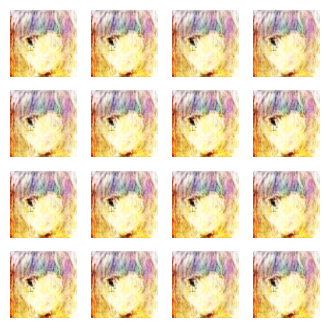

Time for epoch 30 is 50.91 sec
Generator Loss: 3.0532, Discriminator Loss: 0.4593


In [33]:

def generate_and_save_images_silent(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :, :] * 0.5 + 0.5))
      plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.close(fig) 


print("Starting Training...")
train(train_dataset, EPOCHS)

/tmp/ipykernel_47/1639454792.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_47/1639454792.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved: anime_gan_training.gif



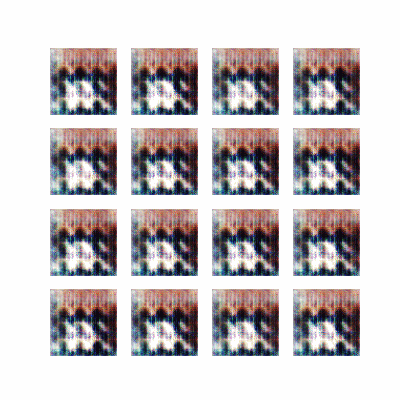

In [42]:
import imageio
import glob

anim_file = 'anime_gan_training.gif'

with imageio.get_writer(anim_file, mode='I') as writer:

  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  

  image = imageio.imread(filename)
  writer.append_data(image)

print(f"GIF saved: {anim_file}")


import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)